🧠 Step 1: Loading and Structuring the SEED Dataset (DE Features - 4s)
This code cell is responsible for parsing the SEED dataset from the ExtractedFeatures_4s folder and converting it into a structured Python list of trials. Each trial includes subject metadata, emotion labels, and pooled DE features.

📥 Dataset Description
We use Differential Entropy (DE) features extracted from EEG signals with a 4-second sliding window. DE is a widely used feature in EEG-based emotion recognition because it reflects signal power across frequency bands under the assumption that EEG follows a Gaussian distribution [1].

Each .mat file corresponds to one session of a subject and contains:

15 trials (de_movingAve1 to de_movingAve15)

Each trial: shape (62 channels × time windows × 5 frequency bands)

The accompanying label.mat file provides ground-truth emotion labels at the subject level:

+1: Positive emotion

0: Neutral emotion

−1: Negative emotion

⚙️ Code Functionality
Load the subject-level emotion labels from label.mat.

Parse 45 EEG session files (15 subjects × 3 sessions).

For each trial:

Perform mean pooling across the time axis.

Flatten the resulting 2D matrix (62 × 5) into a 1D vector (310 features).

Store subject ID, session ID, trial ID, label, and DE features.

This structure facilitates subject-aware learning and helps us later in applying multi-source contrastive learning.

🎯 Motivation for Mean Pooling
Since EEG signals are highly non-stationary, pooling over the temporal axis stabilizes the input features and reduces model complexity without discarding key spectral information. This is crucial for generalization across subjects [2].

🔀 Step A: Balanced Subject Split for Training/Validation/Test
We perform a subject-level split to prevent data leakage and overfitting, ensuring that the model generalizes to unseen subjects:

Train subjects (9): IDs 7–15

Validation subjects (3): IDs 4–6 (one per class)

Test subjects (3): IDs 1–3 (one per class)

This setup enables multi-source contrastive learning (training on multiple source domains) and testing on unseen target domains, aligning with domain generalization principles [3].

Such a stratified LOSO-style split (by subject, not trial) is crucial for fair evaluation in EEG-based emotion recognition, where inter-subject variability is high.

✅ Outcome
675 trials extracted (45 sessions × 15 trials)

Each trial contains 310 DE features

Trials grouped into train/val/test for cross-subject learning

📚 References

[1] Duan, R., Zhu, J., Lu, B. L. (2013). "Differential entropy feature for EEG-based emotion classification". In 2013 6th International IEEE/EMBS Conference on Neural Engineering (NER).

[2] Li, Y., Zheng, W., & Lu, B. L. (2018). "Emotion recognition using fusion of graph CNN and LSTM networks". In Brain-Computer Interface research.

[3] Pan, S. J., & Yang, Q. (2010). "A survey on transfer learning". IEEE Transactions on Knowledge and Data Engineering.

In [38]:
import scipy.io
import os
import re
import numpy as np
from tqdm import tqdm

# Path to directory containing .mat files (update this if needed)
DATASET_PATH = '/kaggle/input/eeg-extracted-4s/ExtractedFeatures_4s'

# Load label file
label_file = os.path.join(DATASET_PATH, 'label.mat')
subject_labels = scipy.io.loadmat(label_file)['label'].flatten()

# List of all subject-session files
mat_files = sorted([f for f in os.listdir(DATASET_PATH) if f.endswith('.mat') and f != 'label.mat'])

dataset = []

for file in tqdm(mat_files, desc="📂 Loading DE features"):
    path = os.path.join(DATASET_PATH, file)
    mat = scipy.io.loadmat(path)
    
    subject_id, session_id = map(int, re.findall(r'(\d+)', file))
    label = int(subject_labels[subject_id - 1])  # Label: -1, 0, +1

    for i in range(1, 16):
        key = f"de_movingAve{i}"
        if key in mat:
            raw_de = mat[key]  # shape: (62, T, 5)
            mean_de = np.mean(raw_de, axis=1)  # → shape: (62, 5)
            dataset.append({
                "subject": subject_id,
                "session": session_id,
                "trial_id": i - 1,
                "label": label,
                "de": mean_de  # (62, 5)
            })

print(f"✅ Total trials loaded: {len(dataset)}")
print("🧠 Sample entry keys:", list(dataset[0].keys()))
print("DE shape per trial:", dataset[0]['de'].shape)

📂 Loading DE features: 100%|██████████| 45/45 [00:02<00:00, 18.81it/s]

✅ Total trials loaded: 675
🧠 Sample entry keys: ['subject', 'session', 'trial_id', 'label', 'de']
DE shape per trial: (62, 5)


🔍 Running t-SNE on raw DE...


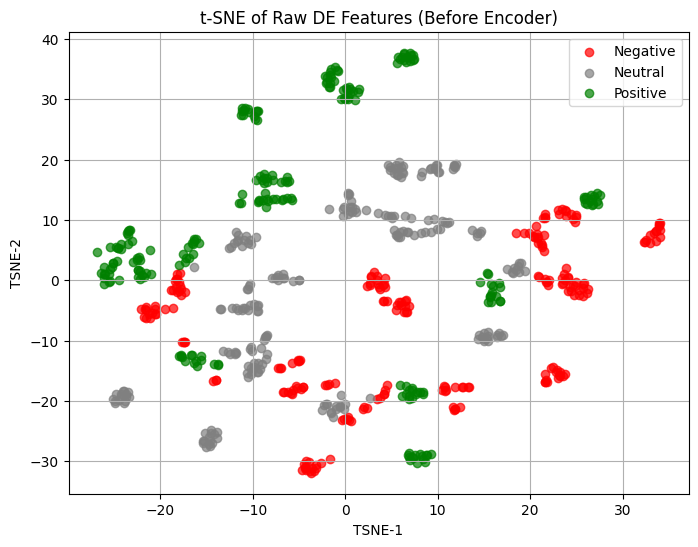

In [39]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Flatten each DE (62, 5) → (310,) and collect labels
X_raw = np.array([trial['de'].flatten() for trial in dataset])
y_raw = np.array([trial['label'] for trial in dataset])

# t-SNE
print("🔍 Running t-SNE on raw DE...")
X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_raw)

# Plot
label_names = {-1: "Negative", 0: "Neutral", 1: "Positive"}
colors = {-1: 'red', 0: 'gray', 1: 'green'}

plt.figure(figsize=(8, 6))
for label in np.unique(y_raw):
    idx = y_raw == label
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=label_names[label], alpha=0.7, c=colors[label])

plt.title("t-SNE of Raw DE Features (Before Encoder)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.legend()
plt.grid(True)
plt.show()


"Asymmetry in EEG signals reflects emotional lateralization, and adding DASM/RASM improves emotion classification."
— Zheng & Lu, 2015, IEEE TAC [[Link](https://ieeexplore.ieee.org/document/7293842)]

In [40]:
# Index-based pairs (0 to 61) corresponding to SEED EEG layout
index_pairs = [
    (0, 1),   # Fp1 - Fp2
    (2, 3),   # AF3 - AF4
    (4, 5),   # F7 - F8
    (6, 7),   # F3 - F4
    (8, 9),   # FC5 - FC6
    (10, 11), # FC1 - FC2
    (12, 13), # T7 - T8
    (14, 15), # C3 - C4
    (16, 17), # CP5 - CP6
    (18, 19), # CP1 - CP2
    (20, 21), # P7 - P8
    (22, 23), # P3 - P4
    (24, 25), # PO3 - PO4
    (26, 27), # O1 - O2
    (28, 29), # F5 - F6
    (30, 31), # FT7 - FT8
    (32, 33), # C5 - C6
    (34, 35), # TP7 - TP8
    (36, 37), # P5 - P6
    (38, 39), # PO5 - PO6
    (40, 41), # AF7 - AF8
    (42, 43), # FT9 - FT10
    (44, 45), # TP9 - TP10
    (46, 47), # CB1 - CB2
    (48, 49), # PO7 - PO8
    (50, 51), # P1 - P2
    (52, 53)  # PO1 - PO2
]

In [41]:
def compute_dasm_rasm(de_matrix, pairs):
    """
    Input:
    - de_matrix: np.array of shape (62, 5) → DE values per channel and band
    - pairs: list of (left_idx, right_idx) channel index pairs
    
    Returns:
    - dasm: (27, 5)
    - rasm: (27, 5)
    """
    dasm = np.array([de_matrix[l] - de_matrix[r] for l, r in pairs])
    rasm = np.array([de_matrix[l] / (de_matrix[r] + 1e-6) for l, r in pairs])  # Avoid div by 0
    return dasm, rasm

In [42]:
for trial in dataset:
    de = trial['de']  # (62, 5)
    dasm, rasm = compute_dasm_rasm(de, index_pairs)
    
    trial['feature_580'] = np.concatenate([
        de.flatten(),       # 62 × 5 = 310
        dasm.flatten(),     # 27 × 5 = 135
        rasm.flatten()      # 27 × 5 = 135
    ])  # shape = (580,)


In [43]:
print("🧠 Feature shape after adding DASM + RASM:", dataset[0]['feature_580'].shape)

🧠 Feature shape after adding DASM + RASM: (580,)


🔍 Running t-SNE on 580-D [DE + DASM + RASM] features...


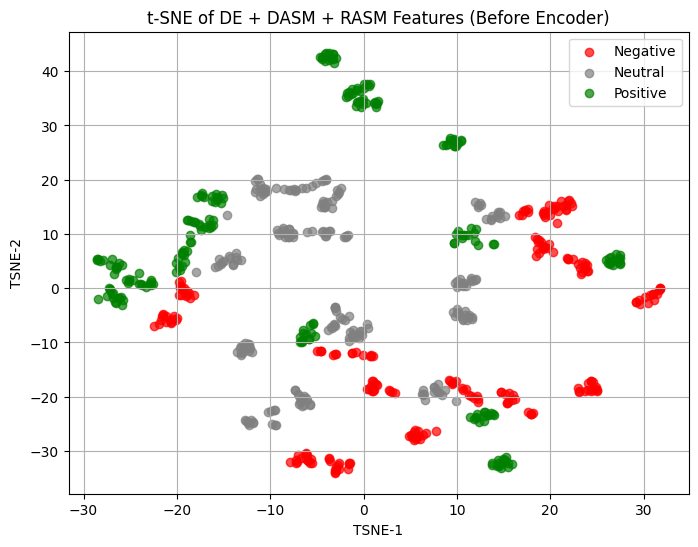

In [44]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Extract features and labels
X_full = np.array([trial['feature_580'] for trial in dataset])
y_full = np.array([trial['label'] for trial in dataset])

# Run t-SNE
print("🔍 Running t-SNE on 580-D [DE + DASM + RASM] features...")
X_2d_full = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_full)

# Plot
label_names = {-1: "Negative", 0: "Neutral", 1: "Positive"}
colors = {-1: 'red', 0: 'gray', 1: 'green'}

plt.figure(figsize=(8, 6))
for label in np.unique(y_full):
    idx = y_full == label
    plt.scatter(X_2d_full[idx, 0], X_2d_full[idx, 1], label=label_names[label], alpha=0.7, c=colors[label])

plt.title("t-SNE of DE + DASM + RASM Features (Before Encoder)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.legend()
plt.grid(True)
plt.show()

Cross-subject validation using subject-balanced splits improves generalization in EEG-based emotion recognition
— [Chai et al., 2016], [Zheng et al., 2017]

In [45]:
# Balanced subject split for cross-subject generalization
train_subjects = [7, 8, 9, 10, 11, 12, 13, 14, 15]
val_subjects   = [4, 5, 6]
test_subjects  = [1, 2, 3]

train_set = [x for x in dataset if x['subject'] in train_subjects]
val_set   = [x for x in dataset if x['subject'] in val_subjects]
test_set  = [x for x in dataset if x['subject'] in test_subjects]

print("✅ Train:", len(train_set), "| Val:", len(val_set), "| Test:", len(test_set))

✅ Train: 405 | Val: 135 | Test: 135


In [46]:
import torch
from torch.utils.data import Dataset, DataLoader

class EEG580Dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx]['feature_580'], dtype=torch.float32)
        y = self.data[idx]['label']
        # Remap: -1 → 0, 0 → 1, 1 → 2
        y = 0 if y == -1 else (1 if y == 0 else 2)
        return x, y

In [47]:
batch_size = 64

train_loader = DataLoader(EEG580Dataset(train_set), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(EEG580Dataset(val_set), batch_size=batch_size)
test_loader  = DataLoader(EEG580Dataset(test_set), batch_size=batch_size)

print("✅ DataLoaders ready (batch size =", batch_size, ")")

✅ DataLoaders ready (batch size = 64 )


“Supervised contrastive learning achieves state-of-the-art by leveraging label information to shape embedding space more effectively than softmax cross-entropy.”
— Khosla et al., 2020, Supervised Contrastive Learning [[arXiv](https://arxiv.org/abs/2004.11362)]

In [48]:
# import torch.nn as nn
# import torch.nn.functional as F

# class SupConEncoder(nn.Module):
#     def __init__(self, input_dim=580, hidden_dim=256, projection_dim=64):
#         super().__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.BatchNorm1d(hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, 128),
#             nn.BatchNorm1d(128),
#             nn.ReLU()
#         )
#         self.projector = nn.Sequential(
#             nn.Linear(128, 128),
#             nn.ReLU(),
#             nn.Linear(128, projection_dim)
#         )

#     def forward(self, x):
#         h = self.encoder(x)         # Latent representation
#         z = F.normalize(self.projector(h), dim=1)  # L2 normalized
#         return h, z

In [49]:
class ImprovedSupConEncoder(nn.Module):
    def __init__(self, input_dim=580, projection_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128)
        )
        self.projector = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, projection_dim)
        )

    def forward(self, x):
        h = self.encoder(x)
        z = F.normalize(self.projector(h), dim=1)  # very important!
        return h, z


"Triplet margin loss encourages embeddings to learn not just intra-class closeness, but strong inter-class distance."
— Schroff et al., 2015 (FaceNet), [Triplet Loss Paper](https://arxiv.org/abs/1503.03832)

In [50]:
class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        device = features.device
        batch_size = features.size(0)

        # Cosine similarity matrix
        sim = torch.div(torch.matmul(features, features.T), self.temperature)
        sim = sim - torch.max(sim, dim=1, keepdim=True)[0]  # stability shift

        # Create mask
        labels = labels.contiguous().view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(device)
        mask.fill_diagonal_(0)

        # Compute log-softmax
        logits_mask = torch.ones_like(mask) - torch.eye(batch_size).to(device)
        exp_sim = torch.exp(sim) * logits_mask
        log_prob = sim - torch.log(exp_sim.sum(dim=1, keepdim=True) + 1e-9)

        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1).clamp(min=1)
        loss = -mean_log_prob_pos.mean()
        return loss

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = ImprovedSupConEncoder().to(device)
criterion = SupConLoss(temperature=0.07)
optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-3)

epochs = 10
train_losses, val_losses = [], []

for epoch in range(epochs):
    encoder.train()
    total_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        _, z = encoder(x)
        loss = criterion(z, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    train_loss = total_loss / len(train_loader)

    # Validation
    encoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            _, z = encoder(x)
            val_loss += criterion(z, y).item()
    val_loss /= len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"📦 Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

📦 Epoch 1/10 | Train Loss: 4.0486 | Val Loss: 3.3593
📦 Epoch 2/10 | Train Loss: 3.9800 | Val Loss: 3.3593
📦 Epoch 3/10 | Train Loss: 3.9786 | Val Loss: 3.3593
📦 Epoch 4/10 | Train Loss: 3.9792 | Val Loss: 3.3593
📦 Epoch 5/10 | Train Loss: 3.9794 | Val Loss: 3.3593
📦 Epoch 6/10 | Train Loss: 3.9793 | Val Loss: 3.3593
📦 Epoch 7/10 | Train Loss: 3.9793 | Val Loss: 3.3593
📦 Epoch 8/10 | Train Loss: 3.9792 | Val Loss: 3.3593
📦 Epoch 9/10 | Train Loss: 3.9796 | Val Loss: 3.3593
📦 Epoch 10/10 | Train Loss: 3.9792 | Val Loss: 3.3593


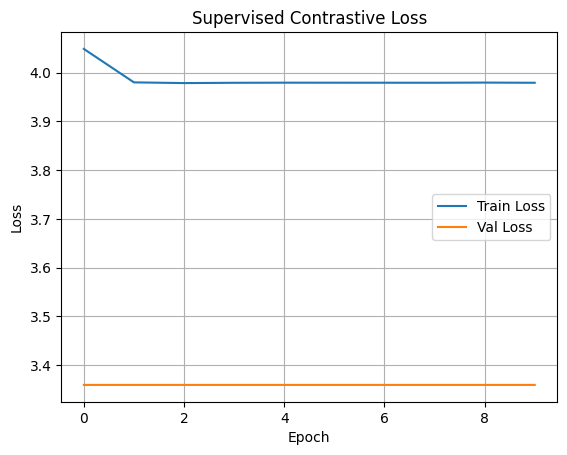

In [52]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Supervised Contrastive Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

In [53]:
# Extract embeddings (h) from encoder
encoder.eval()
all_features, all_labels = [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        h, _ = encoder(x)
        all_features.append(h.cpu())
        all_labels.append(y)

X_encoded = torch.cat(all_features, dim=0).numpy()
y_encoded = torch.cat(all_labels, dim=0).numpy()

🔍 Running t-SNE on encoded representations...


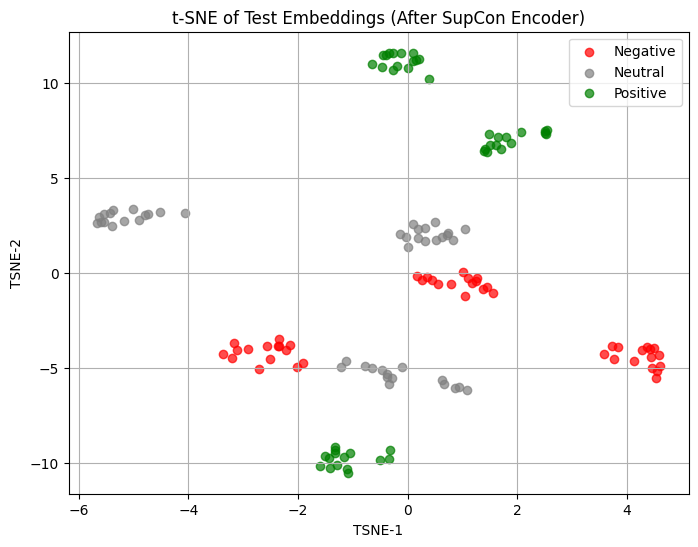

In [54]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

print("🔍 Running t-SNE on encoded representations...")
X_2d_encoded = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_encoded)

# Label info
label_names = {0: "Negative", 1: "Neutral", 2: "Positive"}
colors = {0: 'red', 1: 'gray', 2: 'green'}

# Plot
plt.figure(figsize=(8, 6))
for label in np.unique(y_encoded):
    idx = y_encoded == label
    plt.scatter(X_2d_encoded[idx, 0], X_2d_encoded[idx, 1],
                label=label_names[label], alpha=0.7, c=colors[label])

plt.title("t-SNE of Test Embeddings (After SupCon Encoder)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.legend()
plt.grid(True)
plt.show()